In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
#import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

#import GOSTnet as gn
from make_fishnet import make_fishnet

Populating the interactive namespace from numpy and matplotlib


## Analyzing accessibility to parks in Jeddah, Saudi Arabia

In [3]:
city = ("Jeddah, Saudi Arabia")
city = geocoder.arcgis(city)

In [4]:
bbox = gpd.GeoDataFrame(city.bbox).T

bbox.columns=['lat','lon']
bbox['geometry'] = (list(zip(bbox.lon,bbox.lat)))
bbox['geometry'] = bbox.geometry.apply(lambda x: Point(x))
bbox.set_geometry(bbox['geometry'])

,lat,lon,geometry
northeast,22.02072,39.72179,POINT (39.72179000000007 22.02072000000005)
southwest,20.94272,38.64379,POINT (38.64379000000007 20.94272000000005)


In [5]:
ax = bbox.plot()
mpll.display(fig=ax.figure)

In [6]:
coords = [city.bbox['southwest'][0], city.bbox['southwest'][1], city.bbox['northeast'][0], city.bbox['northeast'][1]] 
coords

[20.94272000000005, 38.64379000000007, 22.020720000000054, 39.72179000000007]

In [7]:
parks_file = pd.read_excel('Final_Parks/Jeddah Parks.xlsx')
parks_shp = gpd.GeoDataFrame(parks_file)

In [8]:
parks_file.head()

,No,Name_E,Name_A,Area_m2,Landscape_Area_m2,E,N
0,1,Aba Al Khaiyl,أبا الخيل,6580,4500.0,39.198446,21.600360
1,2,Al Ajaweed,الأجاويد,4200,2000.0,39.299186,21.397891
2,3,Al Ahwal,الأحوال,4021,2119.0,39.170122,21.623820
3,4,Al Odabaa,الأدباء,6750,1020.0,39.211074,21.560264
4,5,Al Ashbal,الأشبال,1955,747.0,39.193307,21.536075


In [9]:
parks_shp['geometry'] = (list(zip(parks_shp.E,parks_shp.N)))
parks_shp['geometry'] = parks_shp.geometry.apply(lambda x: Point(x))

In [10]:
parks_shp.head()

,No,Name_E,Name_A,Area_m2,Landscape_Area_m2,E,N,geometry
0,1,Aba Al Khaiyl,أبا الخيل,6580,4500.0,39.198446,21.600360,POINT (39.198446 21.60036)
1,2,Al Ajaweed,الأجاويد,4200,2000.0,39.299186,21.397891,POINT (39.299186 21.3978907)
2,3,Al Ahwal,الأحوال,4021,2119.0,39.170122,21.623820,POINT (39.170122 21.62382)
3,4,Al Odabaa,الأدباء,6750,1020.0,39.211074,21.560264,POINT (39.211074 21.560264)
4,5,Al Ashbal,الأشبال,1955,747.0,39.193307,21.536075,POINT (39.193307 21.536075)


In [11]:
network = osm.pdna_network_from_bbox(coords[0], coords[1], coords[2], coords[3])

Requesting network data within bounding box from Overpass API in 9 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](20.94272000,38.64379000,21.30284646,39.00313451);>;);out;'}"
Downloaded 0.3KB from www.overpass-api.de in 0.30 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](21.30246954,38.64380393,21.66258576,39.00314222);>;);out;'}"
Downloaded 0.3KB from www.overpass-api.de in 0.28 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](21.

In [12]:
nodes_gdf = gpd.GeoDataFrame(network.nodes_df)
nodes_gdf['geometry'] = (list(zip(nodes_gdf.x,nodes_gdf.y)))
nodes_gdf['geometry'] = nodes_gdf.geometry.apply(lambda x: Point(x))

In [13]:
nodes_gdf.head()

,x,y,geometry
id,,,
287894981,39.152753,21.630046,POINT (39.152753 21.6300455)
287895278,39.158657,21.600978,POINT (39.1586573 21.600978)
287895279,39.159100,21.599653,POINT (39.1591004 21.5996526)
287895377,39.159221,21.599682,POINT (39.159221 21.5996818)
289240819,39.136038,21.543107,POINT (39.1360382 21.543107)


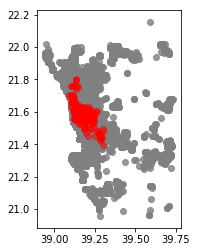

In [38]:
ax = nodes_gdf.plot( color='grey', alpha=0.8)
parks_shp.plot(ax=ax,color='r', alpha=0.5)

In [14]:
network.precompute(3000) # precomputes the nodes that are reachable within 1000 meters

In [15]:
distance = 3000
num_pois = 1

In [16]:
network.set_pois(category='parks',maxdist=distance, maxitems = num_pois, x_col=parks_shp['E'], y_col=parks_shp['N'])

all_access = network.nearest_pois(distance=distance, category='parks', num_pois=num_pois)
print('{:,} nodes'.format(len(all_access)))
all_access.head()

62,528 nodes


,1
id,
287894981,972.318970
287895278,1602.375977
287895279,1756.751953
287895377,1618.792969
289240819,1962.767944


In [25]:
fig_kwargs={'figsize': [30, 14]}
bmap_kwargs={'suppress_ticks': False,'epsg': '4326'}
plot_kwargs={'cmap': 'viridis', 's': 8, 'edgecolor': 'none'}
hex_plot_kwargs = {'gridsize':40,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

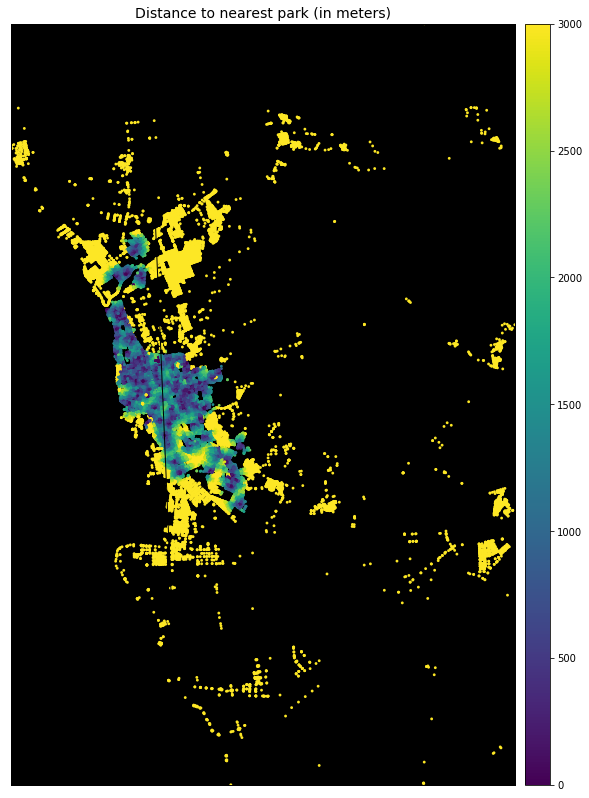

In [26]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
ax.set_title('Distance to nearest park (in meters)', fontsize=14);